In [1]:
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import igraph as ig
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from scipy import stats
from scipy.special import erfc

In [13]:
def heatmapplot(average_degrees, nodes_coordinates, title, label_colorb, year_analyzed):
    lats = [coord[0] for coord in nodes_coordinates.values()]
    lons = [coord[1] for coord in nodes_coordinates.values()]
    degrees = [average_degrees[node] for node in nodes_coordinates.keys()]

    lon_vals = np.linspace(-180, 180, 361)  # Risoluzione di 1 grado in longitudine
    lat_vals = np.linspace(-90, 90, 181)   # Risoluzione di 1 grado in latitudine
    lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

    # Interpolazione
    grid_z = griddata((lons, lats), degrees, (lon_grid, lat_grid), method='linear')

    # BASEMAP
    fig, ax = plt.subplots(figsize=(12, 9))
    #m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=ax)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    
    
    cmap = plt.cm.Oranges                   ####### COLORBAR


    max_degree = max(average_degrees.values())
    min_degree = min(average_degrees.values())
    #max_degree = 0.45   #min_degree = 0.042    #5yr 
    #min_degree = 0.2   #max_degree = 0.075    #5yr


    norm = plt.Normalize(min_degree, max_degree)    #CHOOSE THE LIMIT FOR THE COLOR BAR
    m.drawcoastlines()
    m.fillcontinents(color='lightgray')
    m.drawmapboundary()
    m.drawcountries()
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[False, False, False, True], linewidth=0.5, color='grey')
    m.drawparallels(np.arange(-90., 91., 30.), labels=[True, False, False, False], linewidth=0.5, color='grey')
    # heatmap
    x, y = m(lon_grid, lat_grid)
    m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    sm.set_clim(vmin=min_degree, vmax=max_degree)  

    # COLOR BAR
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Aumenta la dimensione della colorbar se necessario
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(label_colorb, fontsize=16)  # Imposta la dimensione del font della label della colorbar
    cbar.ax.tick_params(labelsize=14)  # Imposta la dimensione del font delle etichette dei tick della colorbar

    ax.set_title(title, loc='center', y=1.05, fontsize =23)

    #plt.savefig(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Area Weighted Connectivity\\Plot\\{title}.png")
    #plt.savefig(f'C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Area Weighted Connectivity\\Plot\\{title}.pdf',bbox_inches='tight',format='pdf')
    percorso_file = f'C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\PLOT\\{title}.pdf.pdf'
    plt.savefig(percorso_file,bbox_inches='tight',format='pdf')
    plt.show()
    plt.close()

def custom_assortativity(G, average_degrees_years):
    edges = G.es()
    E = G.ecount()

    # Calcola le somme necessarie per le formule
    sum_ki_kj = 0
    sum_ki_plus_kj = 0
    sum_ki2_plus_kj2 = 0

    for edge in edges:
        source, target = edge.tuple
        ki = average_degrees_years[source]
        kj = average_degrees_years[target]
        sum_ki_kj += ki * kj
        sum_ki_plus_kj += (ki + kj)
        sum_ki2_plus_kj2 += (ki**2 + kj**2)

    sigma2 = (sum_ki2_plus_kj2 / E) - (sum_ki_plus_kj / (2 * E))**2
    r = ((sum_ki_kj / E) - (sum_ki_plus_kj / (2 * E))**2) / sigma2

    return r

def frobenius_distance(matrix1, matrix2):

    if matrix1.shape != matrix2.shape:
        raise ValueError("Le matrici devono avere la stessa dimensione.")

    difference = matrix1 - matrix2
    frobenius_dist = np.sqrt(np.sum(np.square(difference)))
    
    return frobenius_dist

def generate_adjacency_matrix(prob_matrix):
    random_matrix = np.random.rand(*prob_matrix.shape)
    adjacency_matrix = (random_matrix < prob_matrix).astype(int)
    return adjacency_matrix

def jaccard_distance(matrix1, matrix2):
    """
    Calcola la distanza di Jaccard tra due matrici binarie.
    
    Parameters:
    matrix1, matrix2 (np.array): Due matrici binarie della stessa dimensione.
    
    Returns:
    float: Distanza di Jaccard tra le due matrici.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Le matrici devono avere la stessa dimensione.")
    
    # Calcolo dell'intersezione (elementi uguali a 1 in entrambe le matrici)
    intersection = np.logical_and(matrix1, matrix2).sum()
    # Calcolo dell'unione (elementi uguali a 1 in almeno una delle due matrici)
    union = np.logical_or(matrix1, matrix2).sum()
    
    # Evita la divisione per zero
    if union == 0:
        return 1.0
    
    # Distanza di Jaccard = 1 - (intersezione / unione)
    jaccard_dist = 1 - (intersection / union)
    
    return jaccard_dist

# PARAMETERS

In [6]:

n_year = 52
n_graphs = 100
years_list = []

for i in range(n_year):
    year = 1970 + i
    years_list.append(year)

path = "C:/Users/David/OneDrive/Desktop/CLIMATE_NETWORK/Paper W"

# COORDINATES
nodes_coordinates = {}
with open(f"{path}/network_grid5_hist.txt", 'r') as f:
    for line in f:
        # spezza ogni riga in tre parti: id, latitudine, longitudine
        parts = line.split()
        
        node_id = int(parts[0])
        lat = float(parts[1])
        lon = float(parts[2])
        #if (864 <= int(node_id) < 1800):
        nodes_coordinates[node_id] = (lat, lon)
        

sum_cos_latitudes = sum(math.cos(math.radians(lat)) for lat, _ in nodes_coordinates.values())

distance_matrix = np.load(f"{path}/distance_matrix_corrected.npy")

foutpath2 = "./confronto threshold/" 


thresholds = [0, 1, 5, 50, 75, 90, 95, 99, 100]  # 25,

n_edges = np.zeros((n_year, len(thresholds)))
cc = np.zeros((n_year, len(thresholds)))
rs = np.zeros((n_year, len(thresholds)))
avg =  np.zeros((n_year, len(thresholds)))
frd =  np.zeros((n_year, len(thresholds)))
frd_std =  np.zeros((n_year, len(thresholds)))
jccd =  np.zeros((n_year, len(thresholds)))
jccd_std =  np.zeros((n_year, len(thresholds)))



node_ids = sorted(nodes_coordinates.keys())  # ID dei nodi
years = list(range(1970, 1970 + n_year))  # Anni 

**Bayesian Approach**


In [ ]:
# FUZZY

weighted_degrees_df = pd.DataFrame(index=years, columns=node_ids)
for yr in range(n_year):

    print(f"Analyzing year {yr}")

    prob_array = np.load(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Networks IAAFT\\prob_npy_year{1970+yr}.npy")
    prob_array = np.triu(prob_array, k=+1)

    

    nyr = []
    ccyr = []
    mryr = []
    rsyr = []
    avgyr = []
    frdyr = []
    distances = []


    total_degrees = {node: 0 for node in nodes_coordinates.keys()}
    #avg_neigh_weighted_degree = {node_id: 0 for node_id in nodes_coordinates.keys()}

    for gra in  range(n_graphs):

        #percentile = np.nanpercentile(z_scores_flattened, thresholds[thr])
        print(f'Analysing graph {gra}')

        random_matrix = np.random.rand(*prob_array.shape)
        adjacency_matrix = (random_matrix < prob_array).astype(int)

        G = ig.Graph.Adjacency(adjacency_matrix, mode="upper")


        # Number of edges
        n = G.ecount()
        nyr.append(n)

        # Clustering Coefficient
        coeff = G.transitivity_undirected(mode="NaN")
        ccyr.append(coeff)


        for edge in G.es:
            nodoA, nodoB = edge.tuple
            total_degrees[int(nodoA)] += math.cos(math.radians(nodes_coordinates[int(nodoB)][0]))/sum_cos_latitudes
            total_degrees[int(nodoB)] += math.cos(math.radians(nodes_coordinates[int(nodoA)][0]))/sum_cos_latitudes
        #for edge in G.es:
            #nodoA, nodoB = edge.tuple
            #total_degrees[int(nodoA)] += 1
            #total_degrees[int(nodoB)] += 1


        # assortative mixing
        r = custom_assortativity(G, total_degrees)
        rsyr.append(r)

        # Average Path Length
        all_distances = G.distances()
        all_distances = np.array(all_distances, dtype=float)
        all_distances[all_distances == float('inf')] = np.nan
        average_path_length = np.nanmean(all_distances)
        avgyr.append(average_path_length)

        '''all_shortest_paths = G.shortest_paths(source=None, target=None, mode="OUT") #weights='weight',
        #print(all_shortest_paths)
        # Compute the average path length
        finite_distances = [dist for sublist in all_shortest_paths for dist in sublist if dist < float('inf')]
        if len(finite_distances) > 0:  # To avoid division by zero if all distances are infinite
            average_path_length = sum(finite_distances) / len(finite_distances)
            print(f"Average Path Length for year {1970+yr}: {average_path_length}")
            avg_length = np.mean(all_shortest_paths)

        else:
            print(f"Average Path Length for year {1970+yr}: No finite paths found!")
        avgyr.append(avg_length)'''


    for node in node_ids:
        weighted_degrees_df.loc[1970+yr, node] = total_degrees[node] / n_graphs
    

    n_edges[yr,0] = sum(nyr) / len(nyr)
    cc[yr,0] = sum(ccyr) / len(ccyr)
    rs[yr,0] = sum(rsyr) / len(rsyr)
    avg[yr,0] = sum(avgyr) / len(avgyr)

    n_edges[yr, 1] = np.std(nyr)
    cc[yr, 1] = np.std(ccyr)
    rs[yr, 1] = np.std(rsyr)
    avg[yr, 1] = np.std(avgyr)

In [ ]:
year_analyzed = 1972

for year_analyzed in range(1970, 1970+n_year):
    heatmapplot(dict(weighted_degrees_df.loc[year_analyzed]), nodes_coordinates, f'Area weighted connectivity {year_analyzed}', 'fraction of earth\'s surface connected', 'year_analyzed')
mean_values = weighted_degrees_df.mean(axis=0)
heatmapplot(dict(mean_values), nodes_coordinates, f'Area Weighted Connectivity over 52 Years', 'fraction of earth\'s surface connected', 'year_analyzed')

Analyzing year 0 and threshold 50
35472
Analyzing year 1 and threshold 50
35472
Analyzing year 2 and threshold 50
35472
Analyzing year 3 and threshold 50
35472
Analyzing year 4 and threshold 50
35472
Analyzing year 5 and threshold 50
35472
Analyzing year 6 and threshold 50
35472
Analyzing year 7 and threshold 50
35472
Analyzing year 8 and threshold 50
35472
Analyzing year 9 and threshold 50
35472
Analyzing year 10 and threshold 50
35472
Analyzing year 11 and threshold 50
35472
Analyzing year 12 and threshold 50
35472
Analyzing year 13 and threshold 50
35472
Analyzing year 14 and threshold 50
35472
Analyzing year 15 and threshold 50
35472
Analyzing year 16 and threshold 50
35472
Analyzing year 17 and threshold 50
35472
Analyzing year 18 and threshold 50
35472
Analyzing year 19 and threshold 50
35472
Analyzing year 20 and threshold 50
35472
Analyzing year 21 and threshold 50
35472
Analyzing year 22 and threshold 50
35472
Analyzing year 23 and threshold 50
35472
Analyzing year 24 and thre

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


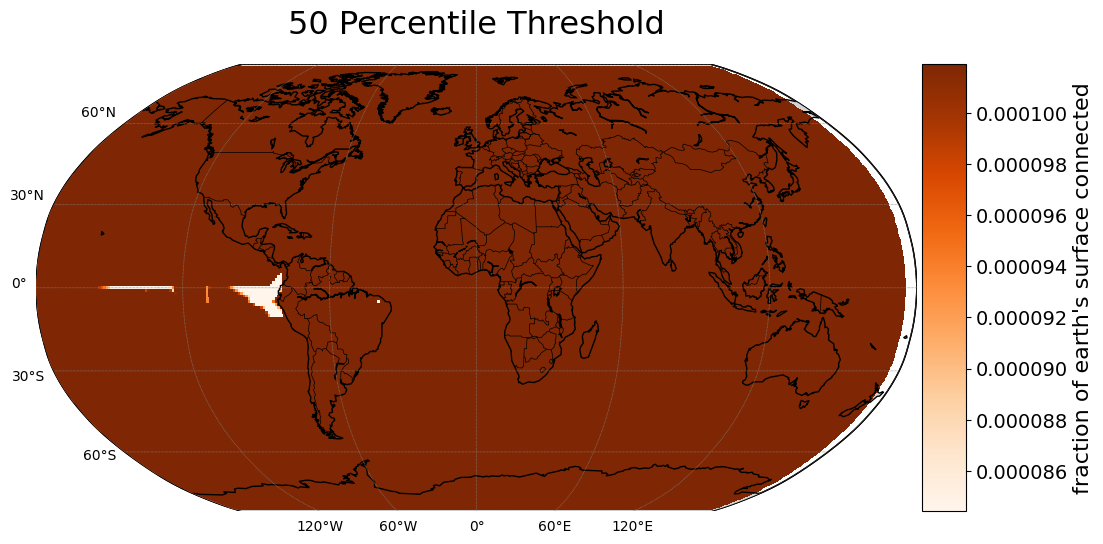

Analyzing year 0 and threshold 75
35472
Analyzing year 1 and threshold 75
35472
Analyzing year 2 and threshold 75
35472
Analyzing year 3 and threshold 75
35472
Analyzing year 4 and threshold 75
35472
Analyzing year 5 and threshold 75
35472
Analyzing year 6 and threshold 75
35472
Analyzing year 7 and threshold 75
35472
Analyzing year 8 and threshold 75
35472
Analyzing year 9 and threshold 75
35472
Analyzing year 10 and threshold 75
35472
Analyzing year 11 and threshold 75
35472
Analyzing year 12 and threshold 75
35472
Analyzing year 13 and threshold 75
35472
Analyzing year 14 and threshold 75
35472
Analyzing year 15 and threshold 75
35472
Analyzing year 16 and threshold 75
35472
Analyzing year 17 and threshold 75
35472
Analyzing year 18 and threshold 75
35472
Analyzing year 19 and threshold 75
35472
Analyzing year 20 and threshold 75
35472
Analyzing year 21 and threshold 75
35472
Analyzing year 22 and threshold 75
35472
Analyzing year 23 and threshold 75
35472
Analyzing year 24 and thre

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


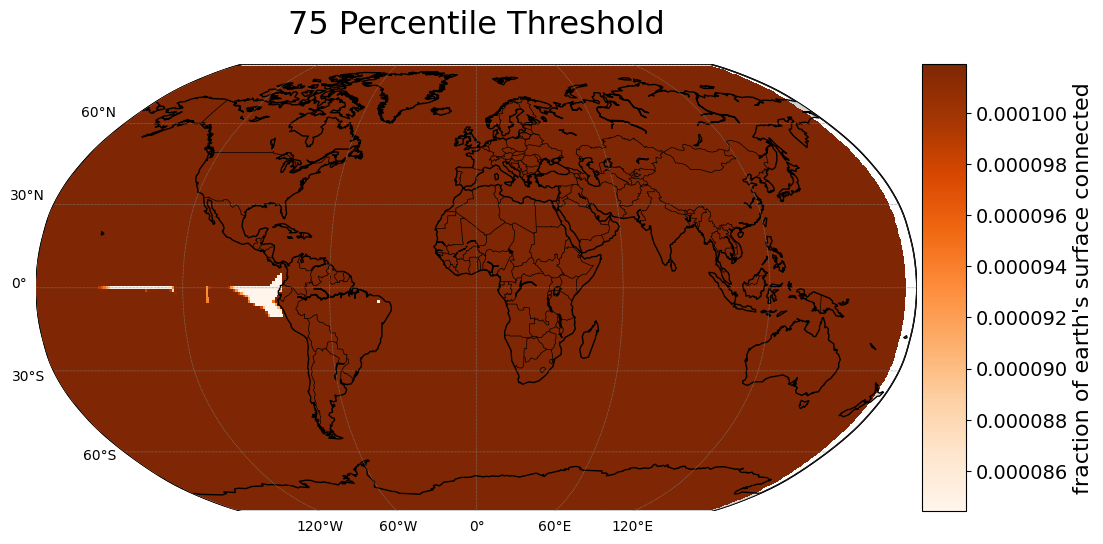

Analyzing year 0 and threshold 90
35472
Analyzing year 1 and threshold 90
35472
Analyzing year 2 and threshold 90
35472
Analyzing year 3 and threshold 90
35472
Analyzing year 4 and threshold 90
35472
Analyzing year 5 and threshold 90
35472
Analyzing year 6 and threshold 90
35472
Analyzing year 7 and threshold 90
35472
Analyzing year 8 and threshold 90
35472
Analyzing year 9 and threshold 90
35472
Analyzing year 10 and threshold 90
35472
Analyzing year 11 and threshold 90
35472
Analyzing year 12 and threshold 90
35472
Analyzing year 13 and threshold 90
35472
Analyzing year 14 and threshold 90
35472
Analyzing year 15 and threshold 90
35472
Analyzing year 16 and threshold 90
35472
Analyzing year 17 and threshold 90
35472
Analyzing year 18 and threshold 90
35472
Analyzing year 19 and threshold 90
35472
Analyzing year 20 and threshold 90
35472
Analyzing year 21 and threshold 90
35472
Analyzing year 22 and threshold 90
35472
Analyzing year 23 and threshold 90
35472
Analyzing year 24 and thre

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


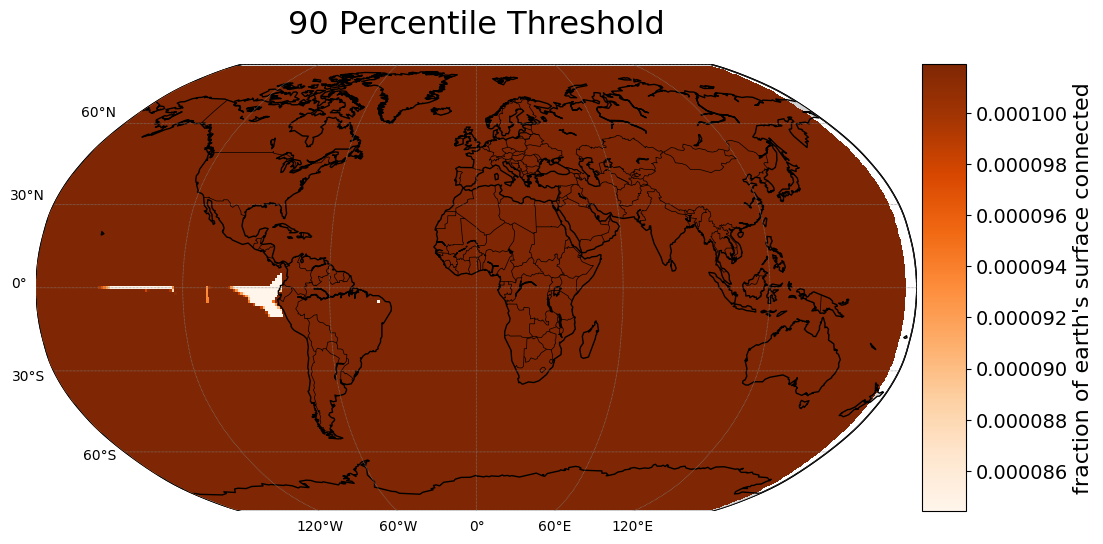

Analyzing year 0 and threshold 95
35472
Analyzing year 1 and threshold 95
35472
Analyzing year 2 and threshold 95
35472
Analyzing year 3 and threshold 95
35472
Analyzing year 4 and threshold 95
35472
Analyzing year 5 and threshold 95
35472
Analyzing year 6 and threshold 95
35472
Analyzing year 7 and threshold 95
35472
Analyzing year 8 and threshold 95
35472
Analyzing year 9 and threshold 95
35472
Analyzing year 10 and threshold 95
35472
Analyzing year 11 and threshold 95
35472
Analyzing year 12 and threshold 95
35472
Analyzing year 13 and threshold 95
35472
Analyzing year 14 and threshold 95
35472
Analyzing year 15 and threshold 95
35472
Analyzing year 16 and threshold 95
35472
Analyzing year 17 and threshold 95
35472
Analyzing year 18 and threshold 95
35472
Analyzing year 19 and threshold 95
35472
Analyzing year 20 and threshold 95
35472
Analyzing year 21 and threshold 95
35472
Analyzing year 22 and threshold 95
35472
Analyzing year 23 and threshold 95
35472
Analyzing year 24 and thre

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


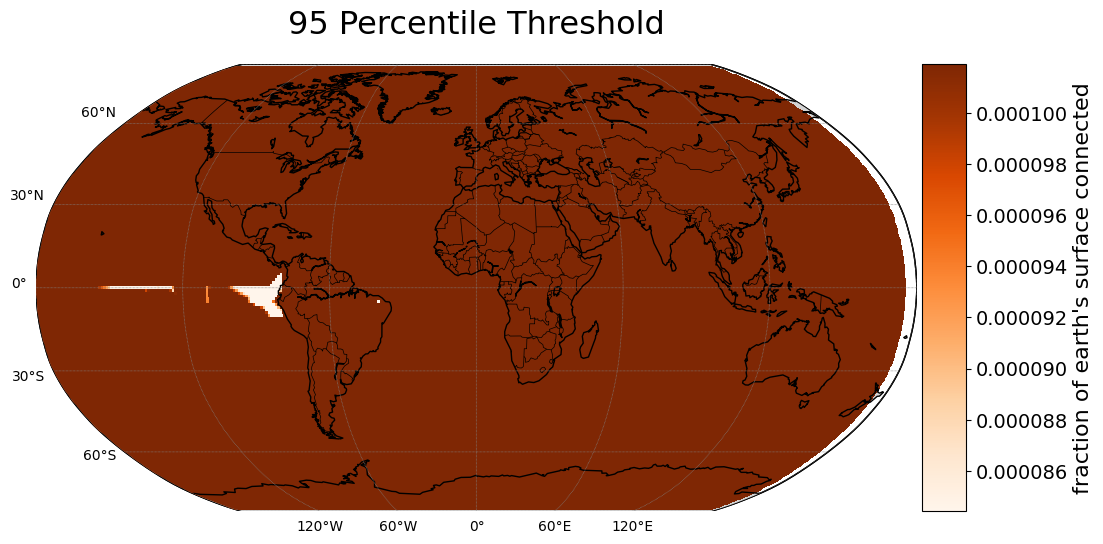

Analyzing year 0 and threshold 99
35472
Analyzing year 1 and threshold 99
35472
Analyzing year 2 and threshold 99
35472
Analyzing year 3 and threshold 99
35472
Analyzing year 4 and threshold 99
35472
Analyzing year 5 and threshold 99
35472
Analyzing year 6 and threshold 99
35472
Analyzing year 7 and threshold 99
35472
Analyzing year 8 and threshold 99
35472
Analyzing year 9 and threshold 99
35472
Analyzing year 10 and threshold 99
35472
Analyzing year 11 and threshold 99
35472
Analyzing year 12 and threshold 99
35472
Analyzing year 13 and threshold 99
35472
Analyzing year 14 and threshold 99
35472
Analyzing year 15 and threshold 99
35472
Analyzing year 16 and threshold 99
35472
Analyzing year 17 and threshold 99
35472
Analyzing year 18 and threshold 99
35472
Analyzing year 19 and threshold 99
35472
Analyzing year 20 and threshold 99
35472
Analyzing year 21 and threshold 99
35472
Analyzing year 22 and threshold 99
35472
Analyzing year 23 and threshold 99
35472
Analyzing year 24 and thre

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


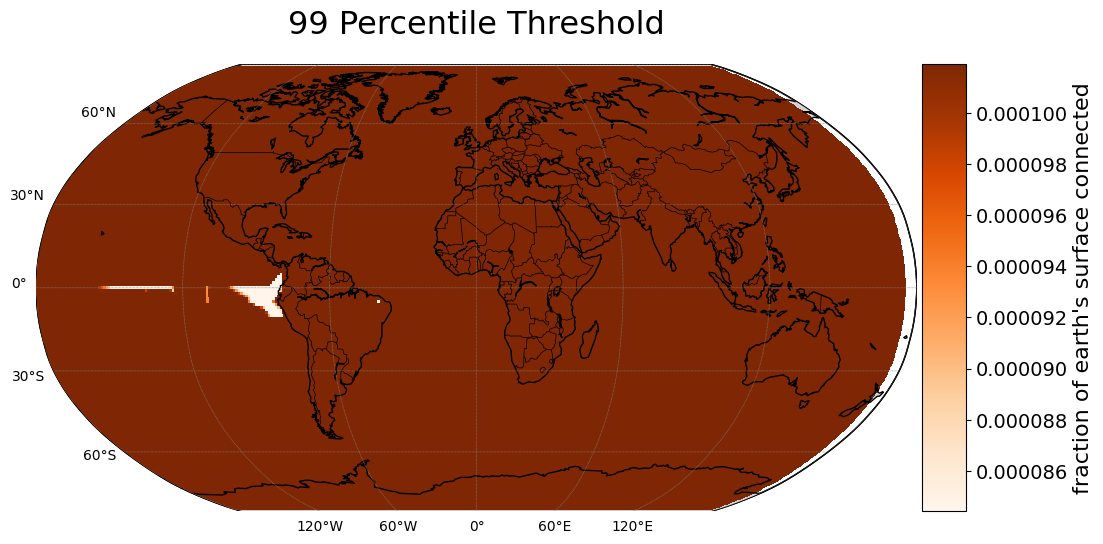

Analyzing year 0 and threshold 100
0.0
5.770372024935347e-07
3547115
Analyzing year 1 and threshold 100
0.0
6.963185445249338e-07
3547115
Analyzing year 2 and threshold 100
0.0
5.393219103187612e-07
3547115
Analyzing year 3 and threshold 100
0.0
6.246224027538437e-07
3547115
Analyzing year 4 and threshold 100
0.0
4.851924060709012e-07
3547115
Analyzing year 5 and threshold 100
0.0
2.902355096995541e-07
3547115
Analyzing year 6 and threshold 100
0.0
1.1458149600022257e-06
3547115
Analyzing year 7 and threshold 100
0.0
8.300567305356339e-07
3547115
Analyzing year 8 and threshold 100
0.0
5.300874911233239e-07
3547115
Analyzing year 9 and threshold 100
0.0
3.777704861294751e-08
3547115
Analyzing year 10 and threshold 100
0.0
8.96730453888022e-08
3547115
Analyzing year 11 and threshold 100
0.0
1.3933295468419524e-07
3547115
Analyzing year 12 and threshold 100
0.0
9.369141610860527e-07
3547115
Analyzing year 13 and threshold 100
0.0
1.975270372688959e-09
3547115
Analyzing year 14 and thresho

C:\Users\David\AppData\Local\Temp\ipykernel_10008\1074757824.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, grid_z, cmap=cmap, norm=norm)


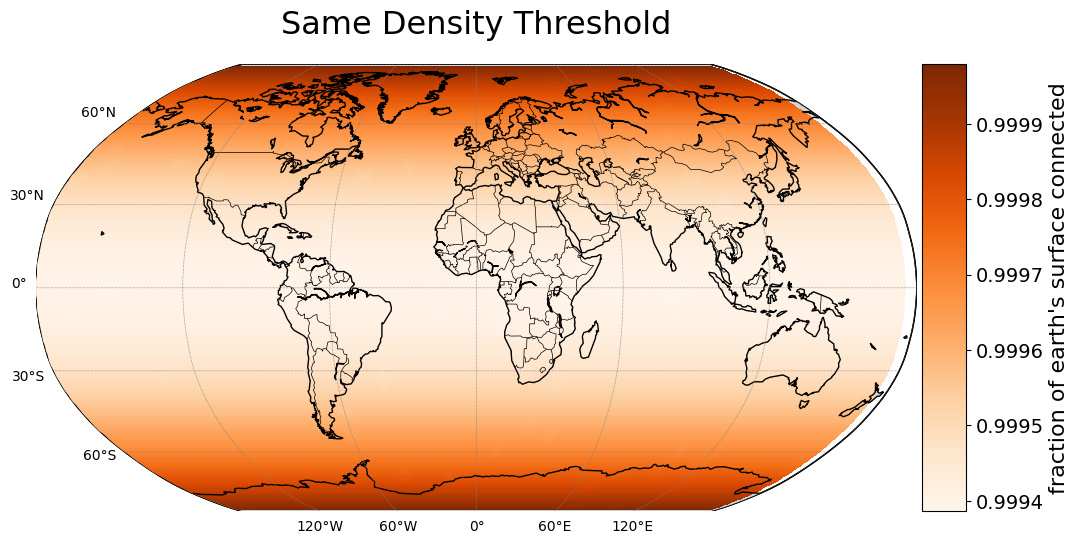

In [15]:
# THRESHOLD
n_year = 52


'''for _ in range(1):
    thr = 2
    for yr in range(n_year):

        
        prob_array = np.load(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Networks IAAFT\\prob_npy_year{1970+yr}.npy")
        prob_array

        z_scores_numpy = np.load(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Zscores IAAFT\\zscores_numpyarray_year{1970+yr}.npy")
        #z_scores_numpy = np.triu(z_scores_numpy, k=+1)
        z_scores_numpy
        z_scores_flattened = z_scores_numpy.flatten()
        z_scores_clean = z_scores_flattened[~np.isnan(z_scores_flattened)]
        p_values = erfc(z_scores_clean / np.sqrt(2))

        p_values_sorted, p_order = zip(*sorted((p_val, i) for i, p_val in enumerate(p_values)))

        # Numero totale di test
        num_tests = len(p_values)
        alpha = 0.10
        # Calcola il fattore di correzione per ciascun p-value
        factors = [i / num_tests * alpha for i in range(1, num_tests + 1)]

        p_value_threshold = max([p for p, f in zip(p_values_sorted, factors) if p < f])

        z_score_threshold = stats.norm.ppf(1 - p_value_threshold/2)
        z_score_threshold

        adj_array = np.empty_like(z_scores_numpy)
        adj_array = np.where(z_scores_numpy > z_score_threshold, 1, 0)

        random_matrix = np.random.rand(*prob_array.shape)
        adjacency_matrix = (random_matrix < prob_array).astype(int)

        G = ig.Graph.Adjacency(adj_array, mode="upper")

        # Number of edges
        n = G.ecount()
        n_edges[yr,thr] = n
        print(n)
        # Clustering Coefficient
        coeff = G.transitivity_undirected(mode="NaN")
        cc[yr,thr] = coeff



        total_degrees = {node: 0 for node in nodes_coordinates.keys()}
        avg_neigh_weighted_degree = {node_id: 0 for node_id in nodes_coordinates.keys()}



        for edge in G.es:
            nodoA, nodoB = edge.tuple
            total_degrees[int(nodoA)] += math.cos(math.radians(nodes_coordinates[int(nodoB)][0]))/sum_cos_latitudes
            total_degrees[int(nodoB)] += math.cos(math.radians(nodes_coordinates[int(nodoA)][0]))/sum_cos_latitudes



        # assortative mixing
        r = custom_assortativity(G, total_degrees)
        rs[yr,thr] = r

        # Average Path Length
        all_distances = G.distances()
        all_distances = np.array(all_distances, dtype=float)
        all_distances[all_distances == float('inf')] = np.nan
        average_path_length = np.nanmean(all_distances)

        avg[yr,thr] = average_path_length



        #distance
        upper_prob_array = np.triu(prob_array, k=1)
        distances = []
        distances_jaccard = []

        for _ in range(50):  # Genera e calcola la distanza per 50 matrici di adiacenza
            adj_array_gen = generate_adjacency_matrix(prob_array)
            distance = frobenius_distance(adj_array, adj_array_gen)
            distances.append(distance)
            distance_jaccard = jaccard_distance(adj_array, adj_array_gen)
            distances_jaccard.append(distance_jaccard) 
            #print(distance)

        distances = np.array(distances)
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)

        frd[yr,thr] = mean_distance
        frd_std[yr,thr] = std_distance

        distances_jaccard = np.array(distances_jaccard)
        mean_distance_jaccard = np.mean(distances_jaccard)
        std_distance_jaccard = np.std(distances_jaccard)
        
        jccd[yr,thr] = mean_distance_jaccard
        jccd_std[yr,thr] = std_distance_jaccard


        for node in node_ids:
            #print(average_degrees_years[node])
            # Riempire il DataFrame con i dati, utilizza `np.nan` se i dati per un nodo specifico mancano
            weighted_degrees_df.loc[1970+yr, node] = total_degrees[node]

    #weighted_degrees_df = weighted_degrees_df.loc[:, ~weighted_degrees_df.columns.str.contains('^Unnamed')]
    righe = weighted_degrees_df.iloc[:]
    sum_over_years = righe.sum()
    allnodesdict = sum_over_years.to_dict()
    allnodesdict = {key: str(value / n_year) for key, value in allnodesdict.items()}

    title_plot  = f"Average Connectivity over 52 Years with FDR Threshold (alpha = 0.05)"
    heatmapplot(allnodesdict, nodes_coordinates, title_plot, 'fraction of earth\'s surface connected', -1919)

    
'''

nyear = 51


for thr in  range(3, len(thresholds)):
#for thr in  range(7, 8):
    weighted_degrees_df = pd.DataFrame(index=years, columns=node_ids)

    for yr in range(nyear):
   
        print(f"Analyzing year {yr} and threshold {thresholds[thr]}")

        z_scores_numpy = np.load(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Zscores IAAFT\\zscores_numpyarray_year{1970+yr}.npy")


        prob_array = np.load(f"C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper\\Networks IAAFT\\prob_npy_year{1970+yr}.npy")
        prob_array = np.triu(prob_array, k=+1)


        #FDR
        z_scores_flattened = z_scores_numpy.flatten()
        z_scores_clean = z_scores_flattened[~np.isnan(z_scores_flattened)]
        # Calcola i p-value usando erfc

        if thresholds[thr] == 5:
            print('FDR')

            z_scores_flattened = z_scores_numpy.flatten()
            z_scores_clean = z_scores_flattened[~np.isnan(z_scores_flattened)]
            p_values = erfc(z_scores_clean / np.sqrt(2))

            p_values_sorted, p_order = zip(*sorted((p_val, i) for i, p_val in enumerate(p_values)))

            # Numero totale di test
            num_tests = len(p_values)
            alpha = 0.05
            # Calcola il fattore di correzione per ciascun p-value
            factors = [i / num_tests * alpha for i in range(1, num_tests + 1)]

            p_value_threshold = max([p for p, f in zip(p_values_sorted, factors) if p < f])

            z_score_threshold = stats.norm.ppf(1 - p_value_threshold/2)
            z_score_threshold

            adj_array = np.empty_like(z_scores_numpy)
            adj_array = np.where(z_scores_numpy > z_score_threshold, 1, 0)

        if thresholds[thr] == 100:
            print(n_edges[yr,0])
            flattened_array = z_scores_numpy.flatten()
            threshold_value = np.partition(z_scores_clean, -int(n_edges[yr,0]))[-int(n_edges[yr,0])]
            print(threshold_value)
            adj_array = np.zeros_like(z_scores_numpy)
            adj_array = np.where(z_scores_numpy > threshold_value, 1, 0)


        else:
            # Calcola la soglia basata sul percentile specificato da thresholds[thr]
            percentile_value = np.percentile(z_scores_clean, 99)
            adj_array = np.where(z_scores_numpy > percentile_value, 1, 0)
            
                        
        #print(adj_array)
        #np.save(f'{foutpath2}/adj_numpyarray_year{1970+yr}_thr{thr}.npy', adj_array)
        G = ig.Graph.Adjacency(adj_array, mode="upper")

        # Number of edges
        n = G.ecount()
        n_edges[yr,thr] = n
        print(n)
        # Clustering Coefficient
        coeff = G.transitivity_undirected(mode="NaN")
        cc[yr,thr] = coeff



        total_degrees = {node: 0 for node in nodes_coordinates.keys()}
        avg_neigh_weighted_degree = {node_id: 0 for node_id in nodes_coordinates.keys()}



        for edge in G.es:
            nodoA, nodoB = edge.tuple
            total_degrees[int(nodoA)] += math.cos(math.radians(nodes_coordinates[int(nodoB)][0]))/sum_cos_latitudes
            total_degrees[int(nodoB)] += math.cos(math.radians(nodes_coordinates[int(nodoA)][0]))/sum_cos_latitudes
        '''for edge in G.es:
            nodoA, nodoB = edge.tuple
            total_degrees[int(nodoA)] += 1
            total_degrees[int(nodoB)] += 1'''


        # assortative mixing
        r = custom_assortativity(G, total_degrees)
        rs[yr,thr] = r

        # Average Path Length
        all_distances = G.distances()
        all_distances = np.array(all_distances, dtype=float)
        all_distances[all_distances == float('inf')] = np.nan
        average_path_length = np.nanmean(all_distances)

        avg[yr,thr] = average_path_length

        '''all_shortest_paths = G.shortest_paths(source=None, target=None, mode="OUT") #weights='weight',
        #print(all_shortest_paths)
        # Compute the average path length
        finite_distances = [dist for sublist in all_shortest_paths for dist in sublist if dist < float('inf')]
        if len(finite_distances) > 0:  # To avoid division by zero if all distances are infinite
            average_path_length = sum(finite_distances) / len(finite_distances)
            #print(f"Average Path Length for year {1970+yr}: {average_path_length}")
            avg_length = np.mean(all_shortest_paths)

        else:
            print(f"Average Path Length for year {1970+yr}: No finite paths found!")
        avg[yr,thr] = avg_length'''


        #distance
        upper_prob_array = np.triu(prob_array, k=1)
        distances = []
        distances_jaccard = []

        for _ in range(50):  # Genera e calcola la distanza per 50 matrici di adiacenza
            adj_array_gen = generate_adjacency_matrix(prob_array)
            distance = frobenius_distance(adj_array, adj_array_gen)
            distances.append(distance)
            distance_jaccard = jaccard_distance(adj_array, adj_array_gen)
            distances_jaccard.append(distance_jaccard) 
            #print(distance)

        distances = np.array(distances)
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)

        frd[yr,thr] = mean_distance
        frd_std[yr,thr] = std_distance

        distances_jaccard = np.array(distances_jaccard)
        mean_distance_jaccard = np.mean(distances_jaccard)
        std_distance_jaccard = np.std(distances_jaccard)
        
        jccd[yr,thr] = mean_distance_jaccard
        jccd_std[yr,thr] = std_distance_jaccard

        '''jsdistance = jensenshannon(upper_prob_array.flatten(), prob_array.flatten())

        random_matrix1 = np.random.rand(*upper_prob_array.shape)
        adjacency_matrix1 = (random_matrix1 < upper_prob_array).astype(int)
        G1 = nx.from_numpy_array(adjacency_matrix1)
        G2 = nx.from_numpy_array(adj_array)
        #print(adjacency_matrix1)
        #print(adj_array)
        jsd_tau[yr,thr] = (JSD(DM(G2,tau),DM(G1,tau)))


        print(jsdistance)
        print(jsd_tau[yr,thr])

        jsd[yr,thr] = (jsdistance)**0.5'''

        for node in node_ids:
            #print(average_degrees_years[node])
            # Riempire il DataFrame con i dati, utilizza `np.nan` se i dati per un nodo specifico mancano
            weighted_degrees_df.loc[1970+yr, node] = total_degrees[node]

    

    #weighted_degrees_df = weighted_degrees_df.loc[:, ~weighted_degrees_df.columns.str.contains('^Unnamed')]
    righe = weighted_degrees_df.iloc[:]
    sum_over_years = righe.sum()
    allnodesdict = sum_over_years.to_dict()
    allnodesdict = {key: str(value / nyear) for key, value in allnodesdict.items()}
    
    #print(allnodesdict)
    if thresholds[thr] == 5:
        print('titolo FDR')
        title_plot  = f"FDR Threshold (alpha = 0.05)"
        heatmapplot(allnodesdict, nodes_coordinates, title_plot, 'fraction of earth\'s surface connected', -1919)
    if thresholds[thr] == 100:
        title_plot = "Same Density Threshold"
    else:
        title_plot = f"{thresholds[thr]} Percentile Threshold"
    
    heatmapplot(allnodesdict, nodes_coordinates, title_plot, 'fraction of earth\'s surface connected', -1919)
